#  Regression


Ceci est un extrait du chapitre 2 du livre d'Aurélien Géron: "Hands-On Machine Learning with Scikit-Learn and TensorFlow". Disponible sur amazon pour un tout petit prix. Et [ici](https://github.com/ageron/handson-ml) se trouve le projet github correspondant. 


Bienvenu dans l'entreprise "qui-veut-tout-prévoir". Votre travail va être de prédire la valeur médiane des maisons en californie, district par district (=county). 



In [0]:
"to load assets on the server (if it was not already done)"
import os
if not os.path.exists("assets_ml"):
  !git clone https://github.com/vincentvigon/assets_ml

In [0]:
%reset -f

In [0]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.pipeline

import warnings
from IPython.display import Image
import os


plt.style.use("default")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.set_printoptions(precision=3,linewidth=500,suppress=True)
np.random.seed(42)
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


assert os.path.exists("assets_ml"), "please import assets via git"

## Les données


### téléchargement

In [0]:
import tarfile
from six.moves import urllib

PROJECT_ROOT_DIR="."

def fetch_housing_data():
    
    """prepare the directory"""
    housing_path=os.path.join(PROJECT_ROOT_DIR,"datasets", "housing")
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    """if the data already fetched we abort"""    
    tgz_path = os.path.join(housing_path, "housing.tgz")
    if os.path.isfile(tgz_path):
        print("data already fetched")
        
    else:
        "downloads the housing.tgz file"
        housing_url="https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz"
        urllib.request.urlretrieve(housing_url, tgz_path)
        "extracts the housing.csv"
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()
        
    csv_path = os.path.join(housing_path, "housing.csv")
    print("data are here:\n",csv_path)
    return csv_path
    

In [0]:
csv_path=fetch_housing_data()
housing_0 = pd.read_csv(csv_path)

data already fetched
data are here:
 ./datasets/housing/housing.csv


### Observons la structure des données

In [0]:
housing_0.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Les variables sont :
* longitude : localisation des districts, longitude
* latitude : localisation des districts, latitude
* housing_median_age : age médian des logement (par district)
* total_rooms : Nombre total de pièces
* total_bedrooms : Nombre total de chambres
* population : Nombre d'habitants dans le district 
* households : Nombre de logements
* median_income : Revenu médian
* median_house_value : Valeur médiane d'un logement (variable cible)
* ocean_proximity : proximité à l'océan

***A vous:***   ($1\heartsuit$) que signifie le résulat suivant ...

In [0]:
len(housing_0.loc[housing_0['total_bedrooms'].isnull()])

207

Il n'y a qu'une seule variable qualitative: `ocean_proximity`


In [0]:
housing_0['ocean_proximity'].value_counts()#ou bien .counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [0]:
"Describtion of all numerical variables"
housing_0.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


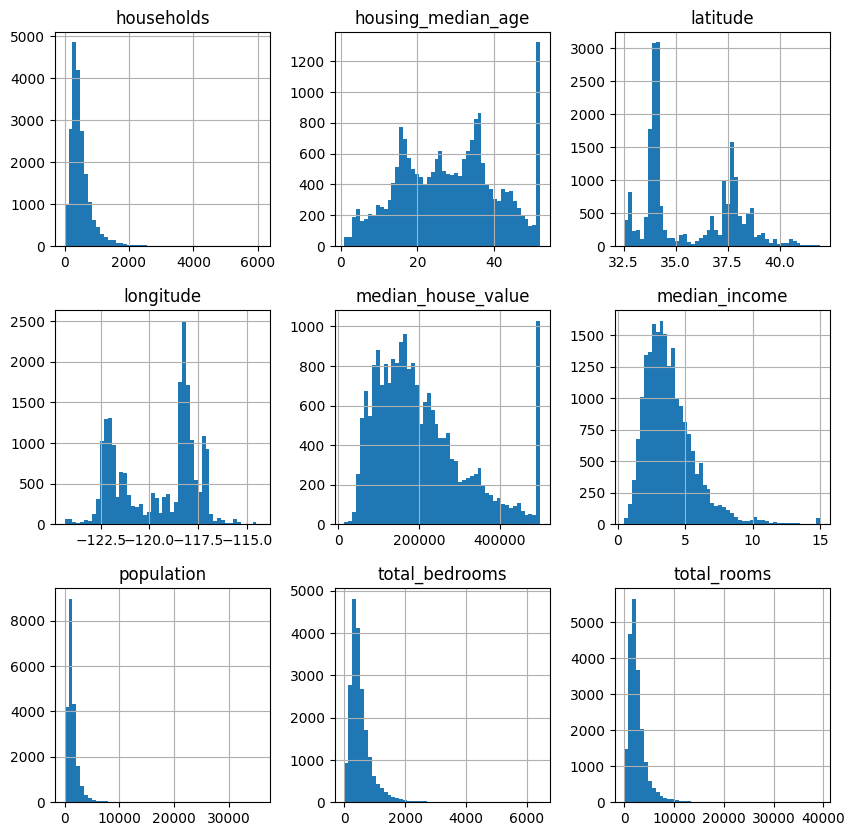

In [0]:
housing_0.hist(bins=50, figsize=(10,10));


* $(\heartsuit)$ `median_income` est-il en dolar ? 
* $(\heartsuit)$ Quels sont les descripteurs qui on été "bornés" (=capped=clipped) ?


Notons que beaucoup d'histogramme ont des "queues lourdes" (=heavy-tail). Les algos préfèrent les distributions en cloche de Gauss. On effectuera quelques prétraitements pour arranger cela. 



## Création d'un jeu de donnée "test"

Pour être vraiment honnête, il faut extraire les données test avant toute observation. Car, à la simple observation d'histogramme, un cerveau de datascientist est capable de sélectionner un modèle ou un prétraitrement particulier (on appelle cela le "data snooping bias"). 

### Premier choix: Random sampling

In [0]:
# Ici on fait fait le splitting à la main.
def my_split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.loc[train_indices], data.loc[test_indices]

In [0]:
my_train_set, my_test_set = my_split_train_test(housing_0, 0.2)
print(len(my_train_set), "train +", len(my_test_set), "test")

16512 train + 4128 test


In [0]:
my_test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


    # voici comment on utilise le spliting de sklearn
    from sklearn.model_selection import train_test_split
    train_set, test_set = train_test_split(housing_0, test_size=0.2, random_state=42)

### Meilleur choix: échantillonnage stratifié (Stratified sampling) 

On divise la population en sous-groupes homogènes (=les strates), puis on va piocher dans chacun des sous-groupes pour remplir les jeux train et test. On obtiendra ainsi deux jeux plus représentatif de la population globale. 

Dans notre jeu de donnée, le 'median income' (revenu médian) est un descripteur naturellement pour stratifier la population. 


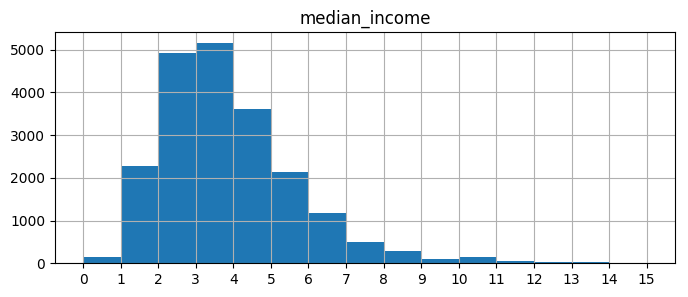

In [0]:
"""ici on améliore la méthode par défaut: housing_0["median_income"].hist()"""
data=housing_0["median_income"].values
fig,ax=plt.subplots(1,1,figsize=(8,3))
bins=np.arange(0,np.max(data),1)
ax.hist(data,bins=bins)
ax.set_xticks(bins)
ax.set_title("median_income")
ax.grid(True);

Il faut créer des strates d'effectif assez grand, pour que le tirage aléatoire à l'intérieur de chaque classe n'engendre pas du "bruit d'échantillonage". 

***A vous:***  Expliquez $(2\heartsuit)$ avec vos mots comment les catégories sont faites ci-dessous.   

In [0]:
housing_0["income_cat"] = np.ceil(housing_0["median_income"] / 1.5)
housing_0["income_cat"].where(housing_0["income_cat"] < 5, 5.0, inplace=True)

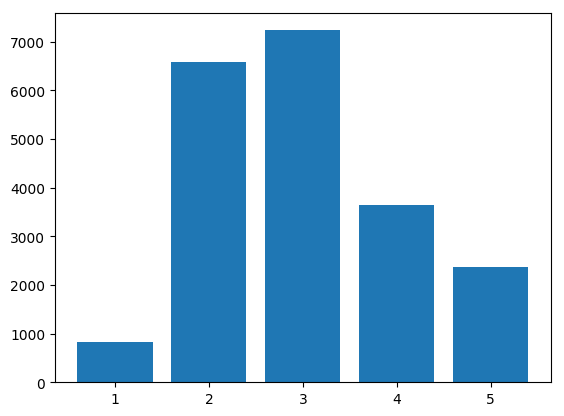

In [0]:
"""ici on améliore la méthode par défaut: housing_0["income_cat"].hist()"""
freq=housing_0["income_cat"].value_counts()
# ou bien avec numpy
# freq=np.unique(housing_0["income_cat"].values,return_counts=True)
plt.bar(freq.index,freq.values);

***A vous:*** Pourquoi $(1\heartsuit \spadesuit)$ n'a-t-on pas utilisé la même technique pour tracer les histogrammes des variables `income_cat` et  `median_income`? (on a utilisé `.bar` et `.hist`)

In [0]:
""" stratified sampling using sklearn"""
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_0, housing_0["income_cat"]):
    strat_train_set = housing_0.loc[train_index]
    strat_test_set = housing_0.loc[test_index]

Vérifions que les strates ont la même répartition dans le jeu test que dans l'ensemble des données. 

In [0]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [0]:
housing_0["income_cat"].value_counts() / len(housing_0)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [0]:
"we do not need 'income_cat' anymore "
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Visualiser les données pour une meilleurs compréhension

In [0]:
"""we keep going with the strafied version.
We make copy, so we can come back to this point."""
housing_1 = strat_train_set.copy()
housing_1_test = strat_test_set.copy()

### Représentation spaciale

Quand on a des données cartographique, il faut dessiner des cartes! Pour des données simples comme les notres, matplotlib suffit, pour des données plus complexe, il faut mieux utiliser geopandas ou carrément des API complexes comme google-map ou ses concurents gratuits! 

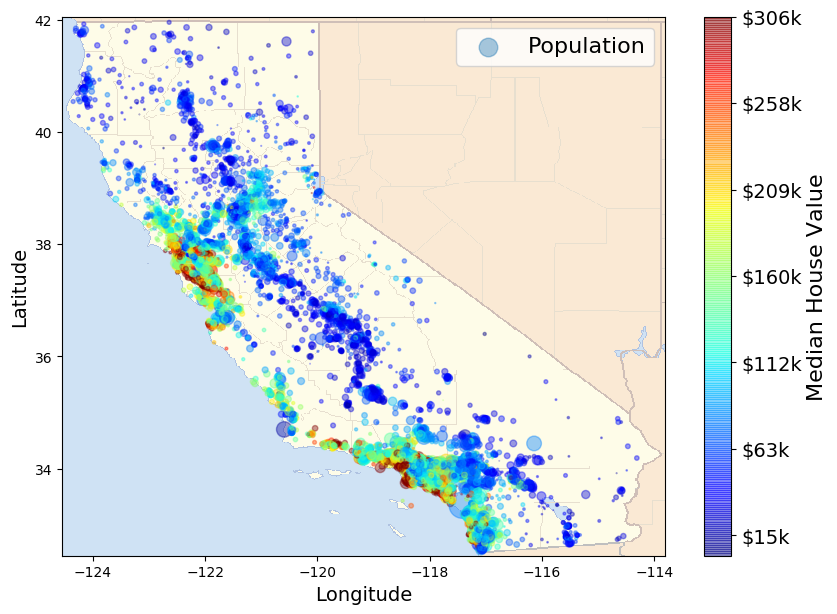

In [0]:
import matplotlib.image as mpimg
california_img=mpimg.imread('assets_ml/img/california.png')

ax = housing_1.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing_1['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing_1["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16);

***A vous:*** $(2\heartsuit)$ D'après cette carte, quels sont les principaux facteur qui influence les prix des maisons? 

***A vous:*** $(2\heartsuit)$ Ajoutez des crois pour les principales villes ci-dessous. $(3\heartsuit)$ Ajoutez le nom des villes (pas facile pour que ce soit lisible).

In [0]:
Ville=np.array([
        [-118.24, 34.05,'Los Angeles'],
       [-117.16, 32.71,'San Diego'],
       [-121.88,37.33, 'San Jose'],
       [-122.41,37.77,'San Francisco'],
       [-119.77,36.74,'Fresno'],
       [-121.49,38.58,'Sacramento'],
       [-118.19,33.77,'Long Beach'],
       [-122.27,37.80,'Oakland'],
       [-119.01,35.37,'Bakersfield'],
       [-117.91,33.83,'Anaheim']
        ])

## Interaction entre variables

Rappelons comment l'on calcul les coefficients de corrélation de Pearson. Au passage on calcule la matrice de covariance. 

On extrait une dataframe formée par les 3 premières colonnes de la dataframe complète. 

***A vous:*** ($1\heartsuit$) Pourrait-on faire les même calcul sur la dataframe complète?

In [0]:
matrix=housing_1[["longitude","latitude","housing_median_age"]].values
print("matrix.dtype:",matrix.dtype)
means=np.mean(matrix,axis=0)
matrix_cen=matrix-means[np.newaxis,:]
cov=matrix_cen.T @ matrix_cen / (len(matrix)-1)
print("my cov:\n",cov)
print("np cov:\n",np.cov(matrix.T))
variance=np.diag(cov)
std=np.sqrt(variance)
std=std[:,np.newaxis]
std_2=std @ std.T
corr=cov/std_2
print("my corr:\n",corr)
print("np corr:\n",np.corrcoef(matrix.T))


matrix.dtype: float64
my cov:
 [[  4.007  -3.957  -2.664]
 [ -3.957   4.571   0.155]
 [ -2.664   0.155 158.124]]
np cov:
 [[  4.007  -3.957  -2.664]
 [ -3.957   4.571   0.155]
 [ -2.664   0.155 158.124]]
my corr:
 [[ 1.    -0.924 -0.106]
 [-0.924  1.     0.006]
 [-0.106  0.006  1.   ]]
np corr:
 [[ 1.    -0.924 -0.106]
 [-0.924  1.     0.006]
 [-0.106  0.006  1.   ]]


### Corrélation linéaire

 La commande `housing_1.corr()` permet d'avoir tous les coefficients de corrélation relatifs à toutes les variables numériques. 


In [0]:
corr_matrix=housing_1.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


Remarque: contrairement à `np.corrcoef()`, la méthode précédente renvoie une dataframe ce qui rend la lecture plus facile.

Mais on peut encore améliorer la présentation avec `seaborn`: 

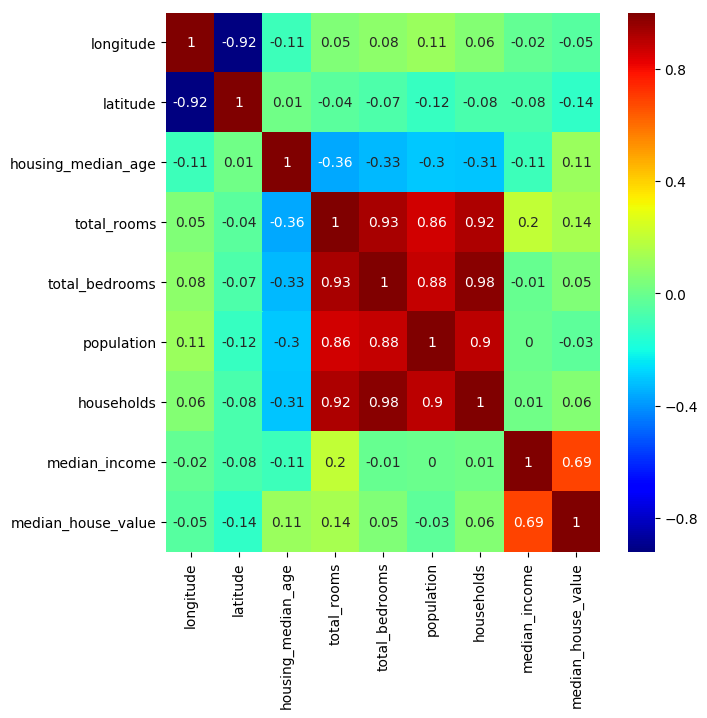

In [0]:
import seaborn as sns
plt.figure(1,figsize=(7,7))
sns.heatmap(np.round(corr_matrix,2), annot=True,cmap="jet");

***A vous:*** $(2\heartsuit)$ Commentez les corrélations qui sont, en valeur absolue, supérieures à 0.3. Il s'agit de donner des arguments de "bon sens". 

Bien sur, les corrélations qui nous intéressent le plus, sont celle entre les descripteurs et la variable cible: 

In [0]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64


### Corrélation de Spearman

Le coefficients de corrélation (de Pearson) entre deux variable $X$ et $Y$ mesurent la relation "linéaire":
* corr(X,Y) = 1 ssi $Y = aX+b$ avec $a > 0$. 
* corr(X,Y) = -1 ssi $Y = aX+b$ avec $a < 0$

En d'autre terme, si on considére des réalisation $(x_i,y_i)$:

* corr(X,Y) = 1 ssi $\forall i: y_i = a x_i+b$ avec $a>0$. 
* corr(X,Y) = -1 ssi $\forall i: y_i = a x_i+b$ avec $a < 0$. 


Introduisons maintenant le coefficient de corrélation de Spearman: il vérifie: 

* spear(X,Y) = 1 ssi $\forall i: y_i = f( x_i)$ avec $f$ croissante. 
* spear(X,Y) = -1 ssi $\forall i: y_i = f(x_i)$ avec $f$ décroissante.

Spearman c'est tout simplement Pearson que l'on calcule à partir du rang des réalisations (et non des réalisation elles même). 

Observons ce calcul.  



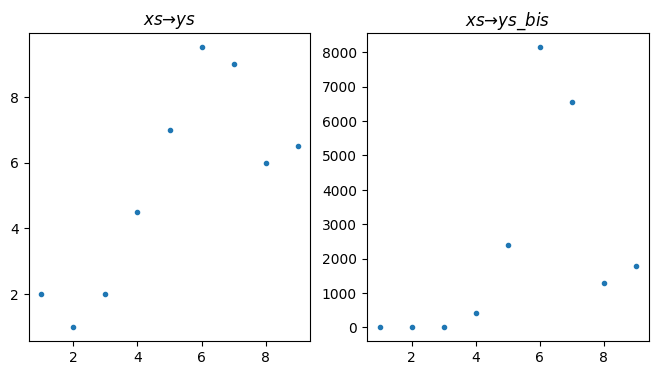

In [0]:
import scipy.stats

# des réalisations de X,Y
xs = np.array([1,2,3,4,5,9,8,7,6])
ys = np.array([2,1,2,4.5,7,6.5,6,9,9.5])
# Y_bis est une variante de Y: 
ys_bis= ys**4

fig,(ax0,ax1)=plt.subplots(1,2,figsize=(8,4))
ax0.plot(xs,ys,'.')
ax0.set_title(r"$xs\to ys$")
ax1.plot(xs,ys_bis,'.')
ax1.set_title(r"$xs\to ys\_bis$");


In [0]:
# rank of x's
xranks = scipy.stats.rankdata(xs)
print("xranks:\n",xranks)
# rank of y's
yranks = scipy.stats.rankdata(ys)
print("yranks:\n",yranks)

xranks:
 [1. 2. 3. 4. 5. 9. 8. 7. 6.]
yranks:
 [2.5 1.  2.5 4.  7.  6.  5.  8.  9. ]


La fonction `np.argsort` renvoie aussi les rangs; mais ce n'est pas la bonne manière pour Spearman.

***A vous:***   Expliquez $(1\heartsuit \spadesuit)$ quelle est la différence?

In [0]:
xranks_argsort = np.argsort(xs)
print("xranks:\n",xranks_argsort)
# rank of y's
yranks_argsort = np.argsort(ys)
print("yranks:\n",yranks_argsort)

xranks:
 [0 1 2 3 4 8 7 6 5]
yranks:
 [1 0 2 3 6 5 4 7 8]


In [0]:
print("Spearman =  Pearson des ranks:",scipy.stats.pearsonr(xranks, yranks)[0])

Spearman =  Pearson des ranks: 0.7029350233548073


In [0]:
"ou bien via la matrice:"
print(np.corrcoef(np.stack([xranks,yranks],axis=1).T))

[[1.    0.703]
 [0.703 1.   ]]


In [0]:
"directement"
print("spearman:",scipy.stats.spearmanr(xs, ys)[0])

spearman: 0.7029350233548073


In [0]:
"avec le jeu de données bis:"
print("spearman:",scipy.stats.spearmanr(xs, ys_bis)[0])

spearman: 0.7029350233548073


***A vous:*** Expliquez $(2\heartsuit)$ pourquoi le coefficient de Spearman entre `X` et `Y` est le même que celui entre `X` et `Y_bis`. 



Comparons maintenant Pearson et Spearman sur nos données 'housing'

In [0]:
corr_pearson=housing_0.corr(method='pearson')
corr_spearman=housing_0.corr(method='spearman')
N=corr_pearson.shape[0]
corr_matrice=np.zeros((N,2))
corr_matrice[:,0]=corr_pearson.loc['median_house_value']
corr_matrice[:,1]=corr_spearman.loc['median_house_value']
df = pd.DataFrame(corr_matrice, index = corr_pearson.index.values, columns = ['Pearson', 'Spearman'])

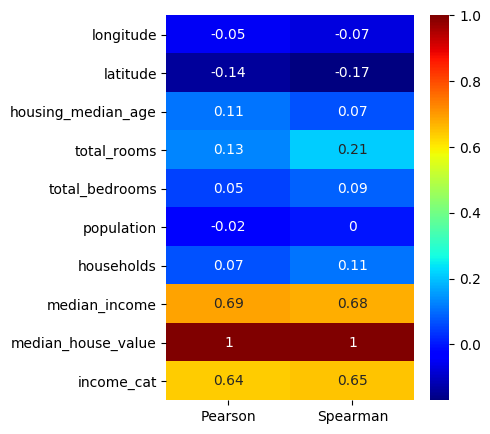

In [0]:
plt.figure(1,figsize=(4,5))
sns.heatmap(np.round(df,2), annot=True,cmap="jet");

***Attention:***   Attention, aucun des coefficients de correlation ne peut rendre compte d'une relations fonctionnelles entre variable. Ex:  si $x$  est proche de zéro alors $y$  devient très grand, mais si $x$ est proche de $1$ alors $y$ devient très petit. C'est logique: on ne peut pas résumer une fonction en un coefficient. C'est pour cela que l'on créer des modèles de données (paramétrés avec plusieurs coefficients). 

### Scatter matrix

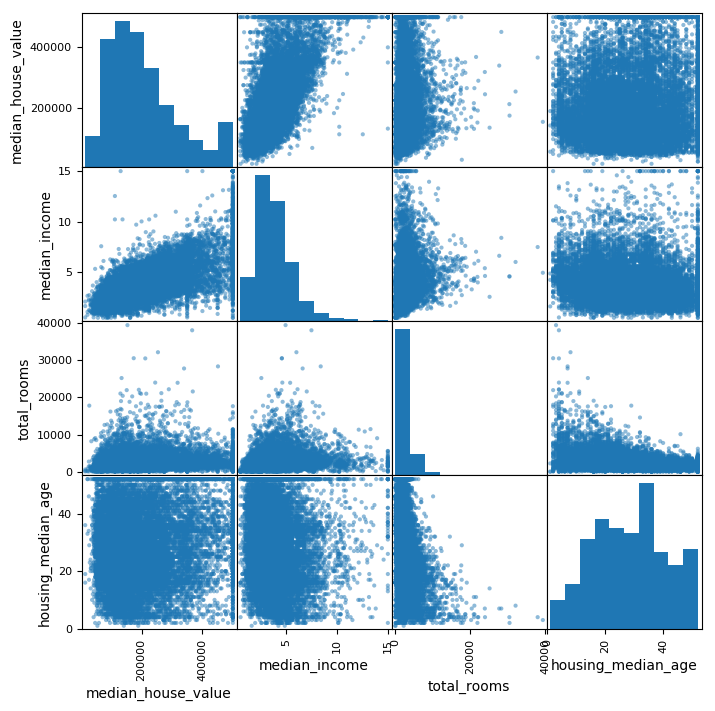

In [0]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing_1[attributes], figsize=(8, 8));


Le prédicteur le plus prométeur pour prédice la valeur médiane des maisons est le revenu médiant. Zoomons dessus:


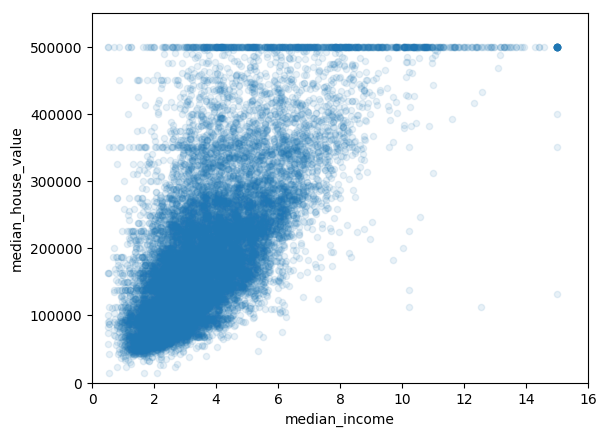

In [0]:
housing_1.plot(kind="scatter", x="median_income", y="median_house_value",alpha=0.1)
plt.axis([0, 16, 0, 550000]);

* La corrélation est très forte
* On revoit que les prix sont seuillé (=cap) à 500 000$
* Mais d'autres lignes horizontales apparaissent:  autour de 450 000, 350 000 et 280 000. Des seuils bizarres. Il faudrait demander à des experts à quoi correspondent ces seuils, puis faire un traitement adéquat pour éviter que notre modèle ne les reproduise. 

## Prétraitement des données

### Netoyage

Nous avions vu que la variable `total_bedrooms` avait des valeurs manquantes.   

In [0]:
""" lines with null values (for 'any' column)"""
housing_1[housing_1.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,175000.0,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,264400.0,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,287100.0,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,95800.0,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,191000.0,<1H OCEAN


Pour arranger cela, plusieurs obtions. 

* Supprimer les lignes correspondantes: `.dropna(subset=["total_bedrooms"])`: mauvaise solution de fénéant. 

*  Supprimer toute la colonne `.drop("total_bedrooms", axis=1)`:  solution dramatique.
        
* Remplacer les valeurs manquantes par la médiane de la colonne:  bonne solution de fénéant. 


***A vous:*** $(2\heartsuit)$ Décrivez une meilleurs solution. 

In [0]:
median = housing_1["total_bedrooms"].median()
housing_1["total_bedrooms"].fillna(median, inplace=True)

Il n'y a donc plus de valeurs manquantes dans la colonne `total_bedrooms`.

***A vous:*** On a nettoyé les données train. Comment $(2\heartsuit)$ pensez-vous nettoyer les données test? Il y a deux choix possible mais un seul des deux respecte la chartre de l'apprentissage: "don't touch test"


### Création de nouveaux descripteurs (=features)

In [0]:
housing_1["rooms_per_household"] = housing_1["total_rooms"]/housing_1["households"]
housing_1["bedrooms_per_room"] = housing_1["total_bedrooms"]/housing_1["total_rooms"]
housing_1["population_per_household"]=housing_1["population"]/housing_1["households"]
housing_1[["rooms_per_household","bedrooms_per_room","population_per_household"]].describe()


,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000
mean,5.440341,0.213703,3.096437
std,2.611712,0.065345,11.584826
min,1.130435,0.036980,0.692308
25%,4.442040,0.175054,2.431287
50%,5.232284,0.203059,2.817653
75%,6.056361,0.240130,3.281420
max,141.909091,2.811688,1243.333333


Regardons de nouveau les corrélations avec la variable cible:  

In [0]:
corr_matrix = housing_1.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047642
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.234240
Name: median_house_value, dtype: float64

Pas mal! le nouveau descripteur `rooms_per_household` est plus corrélé avec la cible que `total_bedrooms` et `total_rooms`. 

[0, 5, 0, 520000]

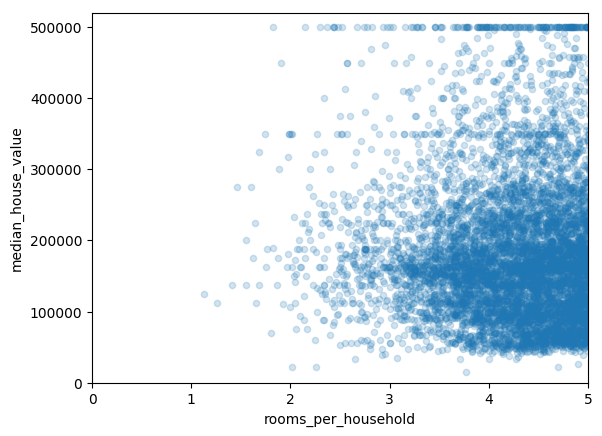

In [0]:
housing_1.plot(kind="scatter", x="rooms_per_household", y="median_house_value",alpha=0.2)
plt.axis([0, 5, 0, 520000])

###  Separation categorical/numérical, input/output

Nous créons trois sous dataframe.

In [0]:
housing_label = housing_1.loc[:,['median_house_value']]
housing_cat = housing_1.loc[:,['ocean_proximity']]
housing_num = housing_1.drop(['median_house_value','ocean_proximity'],axis=1,inplace=False)
print("housing_num columns\n",housing_num.columns.values)

housing_num columns
 ['longitude' 'latitude' 'housing_median_age' 'total_rooms' 'total_bedrooms' 'population' 'households' 'median_income' 'rooms_per_household' 'bedrooms_per_room' 'population_per_household']


### Transformation des variables catégorielles

Nous n'en avons qu'une: c'est `ocean_proximity`. Il nous faut 'binariser' les classes. 

In [0]:
housing_cat['ocean_proximity'].value_counts(dropna=False)

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

In [0]:
""" sklearn technic: all is numpy arrays"""
from sklearn.preprocessing import LabelBinarizer
encoder=LabelBinarizer(sparse_output=False)
X_cat_bin=encoder.fit_transform(housing_cat)

print(X_cat_bin[:10])
print(housing_cat.values[:10])

[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[['<1H OCEAN']
 ['<1H OCEAN']
 ['NEAR OCEAN']
 ['INLAND']
 ['<1H OCEAN']
 ['INLAND']
 ['<1H OCEAN']
 ['INLAND']
 ['<1H OCEAN']
 ['<1H OCEAN']]


Il y a une redondance dans les colonnes de `X_cat_bin`: on peut déterminer la valeur d'une colonne en observant la valeur des 4 autres. Les algo d'apprentissage les plus simple (modèle linéaire, ou GLM) n'aiment pas cette redondance: cela rend la matrice (X.T X) non inversible. 

On peut supprimer la redondance en supprimant une des colonnes. 

In [0]:
"""we supress 'INLAND' to suppress redondance"""
X_cat_bin_=X_cat_bin[:,[0,2,3,4]]
X_cat_names=["<1H OCEAN","NEAR OCEAN","NEAR BAY","ISLAND"]


***Attention:*** Si vous avez des variables catégorielles avec des miliers de classes, il faut utiliser `LabelBinarizer(sparse_output=True)`. Le résultat sera une matrice creuse de `scipy`. 

In [0]:
"""pandas technic: all is pandas dataframe"""
pd.get_dummies(housing_cat,prefix="OP").head()

,OP_<1H OCEAN,OP_INLAND,OP_ISLAND,OP_NEAR BAY,OP_NEAR OCEAN
17606,1,0,0,0,0
18632,1,0,0,0,0
14650,0,0,0,0,1
3230,0,1,0,0,0
3555,1,0,0,0,0


### Question d'échelle

Tous les modèles (à l'exception du modèle linéaire) on besoin d'avoir en entrée des valeurs numérique ni trop grandes ni trop petites. Il faut donc effectuer un scaling (=changement d'échelle).


Observons tout d'abord l'étendue des valeurs avec des boites à moustaches (=box-plot)




X_num.shape (16512, 11)


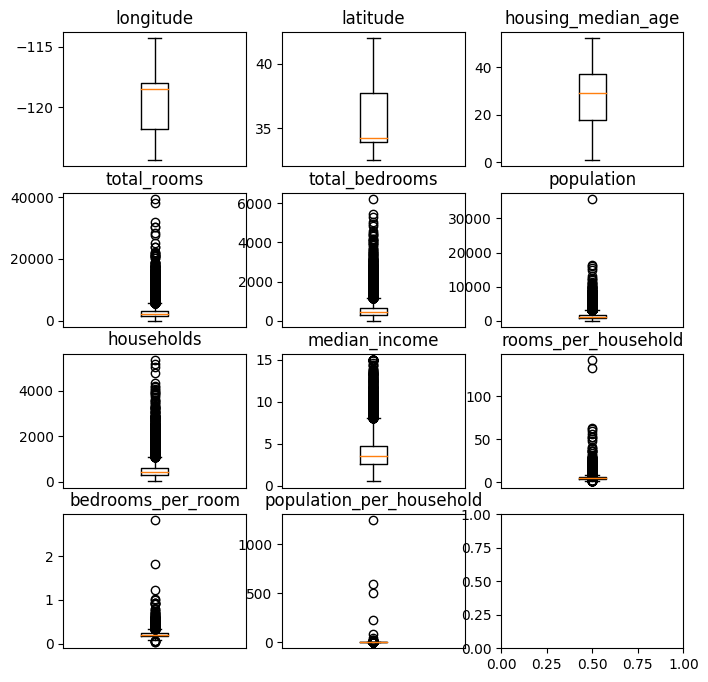

In [0]:
""" here we exit pandas."""
X_num=housing_num.values
"""be keep in memory variable names"""
X_num_names=housing_num.columns.values
print("X_num.shape",X_num.shape)
fig,axs=plt.subplots(4,3)
fig.set_size_inches(8,8)
axs_flat=axs.reshape(-1)# -> vector of Axes
for i in range(X_num.shape[1]):
    ax=axs_flat[i]
    ax.boxplot(X_num[:,i])
    ax.set_title(X_num_names[i])
    ax.set_xticks([])

Explication des boites à moustaches:

* La bare centrale est la médiane
* Le rectangle va du premier quartile Q1 au dernier quartile Q3, il contient donc la moitié des données. 
* La moustache est calculée en utilisant la longeur de la boite Q1-Q3. Elle va de Q1-1.5 (Q1-Q3) jusqu'à Q3-1.5(Q1-Q3)
* Les points en dehors de la mousches sont représentée. Il représente des valeurs exceptionnellement grandes (mais pas forcément 'abhérentes')
* Typiquement, pour une variable gaussienne, la proba qu'une réalisation tombe en dehors des moustaches est très très faible. 




  



### Standardiser (=centrer-réduire)

 

La méthode de scaling la plus classique est la standardisation: on soustrait à chaque variable numérique sa moyenne puis on  divise par l'écart-type. 

Il est habituel de 'fiter' le scaler sur les données train uniquement: on calcule moyennes et les écarts-types sur train. Ensuite on centre-réduit train et test avec ces moyennes et écart types. 


L'autre solution serait de centrer-réduire train et test indépendamment avec leur propre moyennes et écart-type. Mais il faut imaginer que les données test peuvent arriver à posteriori et être très petites (ex: 2 lignes). Cela n'a pas de sens de calculer une moyenne et un écart type dessus.  


Cependant cette règle peu connaitre des exceptions. Par exemple: les jeux de données arrivent par paquets, et proviennent d'appareils dont le qualibrage change avec le temps. Dans ce cas, il est naturel de centrer-réduire systèmatiquement les paquets de données. 


In [0]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_num_st=scaler.fit_transform(X_num)
print("X_num_st.shape:",X_num_st.shape)

X_num_st.shape: (16512, 11)


Après standardisation:


In [0]:
print(np.mean(X_num_st,axis=0))
print(np.std(X_num_st,axis=0))

[-0.  0. -0.  0.  0. -0.  0. -0.  0. -0. -0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Min-max scaling


In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
MinMax=MinMaxScaler()
X_num_MinMax=MinMax.fit_transform(X_num)

print(X_num_MinMax.min(axis=0))
print(X_num_MinMax.max(axis=0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]




* Avantage du min-max scaler: Cela aide certains algo d'avoir des valeurs toutes dans le même intervalle.
* Incovénient du min-max scaler: Si il y a des valeurs extrèmes, elles vont écraser les autres valeurs. 

Conseil: utiliser un min-max scaleur uniquement pour des valeurs numériques dont l'échelle est bien déterminée. Ex: la valeur d'un pixel entre 0 et 255. 

Il existe un autre scaler: le 'tanh-estimator': 
$$
\frac 12 \Big(\tanh\big( \frac{x-\bar x}{100 \sigma}\big)  +1     \Big)
$$
***A vous:*** ($1\heartsuit$) Avantage?


### Union de tous les imputs

 

In [0]:
X=np.concatenate([X_num_st,X_cat_bin_],axis=1)
print("X.shape:",X.shape)

Y=housing_label.values.reshape(-1)
print("Y.shape",Y.shape)

X_names=np.concatenate([X_num_names,X_cat_names])
print("X_name\n",X_names)

X.shape: (16512, 15)
Y.shape (16512,)
X_name
 ['longitude' 'latitude' 'housing_median_age' 'total_rooms' 'total_bedrooms' 'population' 'households' 'median_income' 'rooms_per_household' 'bedrooms_per_room' 'population_per_household' '<1H OCEAN' 'NEAR OCEAN' 'NEAR BAY' 'ISLAND']


## Création d'un pipeline de prétraitement

Notre input X et notre output Y sont prêt pour être servi aux algos de machine learning. 

Mais nous allons enpaqueter tous les prétraitement dans un pipeline, qui sera aussi appliqué au jeu test (sauf que nous ne fiterons jamais sur test).

  

In [0]:
class MyPipeline():
        
    """this method is automaticaly called we buid the object i.e. we write pipeline=MyPipeLine() """
    def __init__(self):
        
        self._scaler=sklearn.preprocessing.StandardScaler()
        self._was_fit=False
        
        self.X_names=None

    
    def fit_transform(self,housing_train):
        self._was_fit=True

        self.median = housing_train["total_bedrooms"].median()
        housing_train["total_bedrooms"].fillna(self.median, inplace=True)
        self._add_features(housing_train)
            
        return self._endOfPipeline(housing_train,True)
           
       
    
    def transform(self,housing_test):
        assert self._was_fit, "please call 'fit_transform()' before 'transform()' "
        
        #do not compue median!
        housing_test["total_bedrooms"].fillna(self.median, inplace=True)
        self._add_features(housing_test)
        
        return self._endOfPipeline(housing_test,False)
        


    """ methods starting with underscore are private methods: for internal use only"""
    
    def _add_features(self,housing):
        housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
        housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
        housing["population_per_household"]=housing["population"]/housing["households"]
        
    def _endOfPipeline(self,housing,do_fit):
        housing_label = housing.loc[:,['median_house_value']]
        housing_cat = housing.loc[:,['ocean_proximity']]
        housing_num = housing.drop(['median_house_value','ocean_proximity'],axis=1,inplace=False)
        
        encoder=LabelBinarizer(sparse_output=False)
        X_cat_1hot=encoder.fit_transform(housing_cat)
        X_cat_1hot=X_cat_1hot[:,[0,2,3,4]]
        X_cat_names=encoder.classes_[[0,2,3,4]]
        
        X_num=housing_num.values
        X_num_names=housing_num.columns.values
        
        if do_fit:
            X_num_st=self._scaler.fit_transform(X_num)
        else: 
            X_num_st=self._scaler.transform(X_num)
            
            
        X=np.concatenate([X_num_st,X_cat_1hot],axis=1)
        self.X_names=np.concatenate([X_num_names,X_cat_names])
        Y=housing_label.values.reshape(-1)
        
        return X,Y

Remarque: l'emploi d'un objet (et pas d'une fonction) se justifie ici: on a besoin de stocker certaines valeurs:
*  la moyenne et l'écart-type de toutes les variables
*  la médiane de total_bedrooms.

Nous voilà prêt pour créer `X_train,X_test` et `Y_train,Y_test`.

In [0]:
pipeLine=MyPipeline()
X_train,Y_train=pipeLine.fit_transform(housing_1)
X_test,Y_test=pipeLine.transform(housing_1_test)
X_names=pipeLine.X_names

""" we check that MyPipeline.fit_transform() make the same job as our exploratory job."""
print(X_train[:5,:])
print(X[:5,:])
print("X_names\n",X_names)

[[-1.156  0.772  0.743 -0.493 -0.445 -0.636 -0.421 -0.615 -0.312  0.155 -0.086  1.     0.     0.     0.   ]
 [-1.176  0.66  -1.165 -0.909 -1.037 -0.998 -1.022  1.336  0.218 -0.836 -0.034  1.     0.     0.     0.   ]
 [ 1.187 -1.342  0.187 -0.314 -0.153 -0.434 -0.093 -0.532 -0.465  0.422 -0.092  0.     0.     0.     1.   ]
 [-0.017  0.314 -0.291 -0.363 -0.397  0.036 -0.383 -1.046 -0.08  -0.196  0.09   0.     0.     0.     0.   ]
 [ 0.492 -0.659 -0.927  1.856  2.412  2.724  2.571 -0.441 -0.358  0.27  -0.004  1.     0.     0.     0.   ]]
[[-1.156  0.772  0.743 -0.493 -0.445 -0.636 -0.421 -0.615 -0.312  0.155 -0.086  1.     0.     0.     0.   ]
 [-1.176  0.66  -1.165 -0.909 -1.037 -0.998 -1.022  1.336  0.218 -0.836 -0.034  1.     0.     0.     0.   ]
 [ 1.187 -1.342  0.187 -0.314 -0.153 -0.434 -0.093 -0.532 -0.465  0.422 -0.092  0.     0.     0.     1.   ]
 [-0.017  0.314 -0.291 -0.363 -0.397  0.036 -0.383 -1.046 -0.08  -0.196  0.09   0.     0.     0.     0.   ]
 [ 0.492 -0.659 -0.927  1.8

## Sélectionnons et entrainons un modèle

Ici commence le machine-learning. Commençons par l'algo le plus simple. 


### Modèle linéaire

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
Y_train_hat=lin_reg.predict(X_train);

Attention, dans les objets de sklearn, il ne faut rentrer que des matrices numpy. Si on  rentre une dataframe pandas, l'index sera utilisé comme un descripteur!!! 

Par contre, on peut utiliser pandas à posteriori pour présenter les résultats:

In [0]:
import pandas as pd
def present_result(nb=10):
    df=pd.DataFrame({
        "Y_train_hat":np.round(Y_train_hat[:nb]),
        "Y_train":Y_train[:nb]
    })
    return df

present_result()

,Y_train_hat,Y_train
0,210645.0,286600.0
1,317769.0,340600.0
2,210956.0,196900.0
3,59219.0,46300.0
4,189748.0,254500.0
5,154295.0,127900.0
6,426712.0,500001.0
7,228003.0,140200.0
8,139801.0,95000.0
9,30128.0,500001.0


In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def show_metrics():
    """mean square error"""
    mse = mean_squared_error(Y_train, Y_train_hat)
    """root mean square error"""
    rmse = np.sqrt(mse)
    """mean absolute error """
    mae = mean_absolute_error(Y_train, Y_train_hat)

    print("lin_rmse:",rmse)
    print("lin_mae:",mae)
    
show_metrics()

lin_rmse: 68628.19819848923
lin_mae: 49439.89599001897


***A vous:*** Recalculez $(2\heartsuit)$ la MSE et MAE avec `numpy` sans utiliser `sklearn`. Laquelle $(1\heartsuit)$ de ces deux metriques est la plus sévère avec les grosses erreurs; notamment les erreur provenant de valeurs abhérante? 

### Decision Tree

In [0]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, Y_train)
Y_train_hat=tree_reg.predict(X_train)

present_result()

,Y_train_hat,Y_train
0,286600.0,286600.0
1,340600.0,340600.0
2,196900.0,196900.0
3,46300.0,46300.0
4,254500.0,254500.0
5,127900.0,127900.0
6,500001.0,500001.0
7,140200.0,140200.0
8,95000.0,95000.0
9,500001.0,500001.0


In [0]:
show_metrics()

lin_rmse: 0.0
lin_mae: 0.0


Quoi? Pas d'erreur du tout!

Le modèle a overfitter les données train. Il nous faudrait un autre moyen pour évaluer l'erreur. Et il est encore trop tot pour utiliser le jeu test (on l'utilisera qu'une fois que l'on aura choisi le modèle et ses hyper-paramètres). 

On a donc deux technique pour valider notre modèle: 

* La validation simple: au tout début on sépare les données en train/validation/test et on validera sur le jeu 'validation'. 
* la validation croisée ...

### Validation croisée

On découpe le jeu train en 10 parties, appelée feuille (=fold). Puis on entraine et évalue le modèle 10 fois, en prenant à chaque fois une feuille différente pour l'évaluation, et les 9 autres pour l'entrainement.  

In [0]:
def my_cross_validation(model,X_train,Y_train,nbFolds=10,loss_choice="mae", verbose=False):   
    
    n=X_train.shape[0] #nb line
    q=X_train.shape[1] #nb variables
    quotient=n//nbFolds
    remainder=n%nbFolds
    X_fold=X_train[:-remainder,:].reshape([nbFolds,quotient,q])
    Y_fold=Y_train[:-remainder].reshape([nbFolds,quotient])
    
    losses=np.zeros(nbFolds)
        
    for i in range(nbFolds):
        if verbose: print("cross validation, fold:",i)
        all_but_i=[k for k in range(nbFolds) if k !=i]
        X=np.concatenate(X_fold[all_but_i,:,:],axis=0)
        Y=np.concatenate(Y_fold[all_but_i,:],axis=0)
        model.fit(X,Y)
        Y_hat_i=model.predict(X_fold[i,:,:])
        
        
        if loss_choice=="mae":
            losses[i]=np.mean(np.abs((Y_fold[i,:]-Y_hat_i)))
        elif loss_choice=="rmse":
            losses[i]=np.sqrt(np.mean((Y_fold[i,:]-Y_hat_i)**2))
        elif loss_choice=="mse":
            losses[i]=np.mean((Y_fold[i,:]-Y_hat_i)**2)
        else : raise Exception("loss_choice can be 'mae' or 'rmse' or 'mse' ")
        
    return losses
  

In [0]:
print("LINEAR REGRESSION")
losses=my_cross_validation(lin_reg,X_train,Y_train,nbFolds=10,loss_choice="mae")
print("bias:",np.mean(losses))
print("variance:",np.std(losses))

LINEAR REGRESSION
bias: 49561.045976614776
variance: 1224.8952400711685


In [0]:
print("DECISSION TREE")
losses=my_cross_validation(tree_reg,X_train,Y_train,10,loss_choice="mae")
print("bias:",np.mean(losses))
print("variance:",np.std(losses))

DECISSION TREE
bias: 45413.38449424591
variance: 781.3373719466678


Remarquons aussi que la validaton croisée permet d'estimer la variabilité de notre modèle (ce qu'on appelle aussi simplement la variance du modèle). 

La simple validation ne donne que le biais. 

Rappel: Erreur quadratique = Variance + Biais

* la variance : l'erreur due à la sensibilité aux variations des données d'entrainement. Plus un modèle est flexible, plus sa variance est grande.
* le biais : l'erreur due à un modèle trop éloigné des données

Voici la méthode de `sklearn` pour la validation croisée. Attention, sklearn veux un score (plus c'est haut, plus c'est mieux) et pas une loss. On va donc utiliser `neg_mean_absolute_error`: l'opposé de la MAE.  


In [0]:
from sklearn.model_selection import cross_val_score
losses = -cross_val_score(tree_reg, X_train, Y_train,scoring="neg_mean_absolute_error", cv=10)
print("DECISSION TREE, CV WITH SKLEARN")
print("mean score:",np.mean(losses))
print("sdt score:",np.std(losses))

DECISSION TREE, CV WITH SKLEARN
mean score: 45246.88311878632
sdt score: 1047.19362303185


### Random forest 

La forêt aléatoire est un ensemble d'arbre de décisions entrainé sur des sous-ensembles différents de descripteurs. On moyenne ensuite les prédictions de chacun des arbre pour obtenir la prédiction de la forêt. On vera cela plus en détail plus tard. 



In [0]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42,n_estimators=6,max_features=6)
scores_rmse=my_cross_validation(forest_reg,X_train,Y_train,10)
print("RANDOM FOREST")
print("mean rmse:",np.mean(scores_rmse))
print("sdt rmse:",np.std(scores_rmse))

RANDOM FOREST
mean rmse: 36304.48411064002
sdt rmse: 1109.33561797479


##  Ajustons les hyper-paramètres (Fine-Tuning) 


### recherche par quadrillage (Grid search)

Les hyper-paramètres d'une forêt aléatoire sont: 

* `max_features`
* `bootstrap`
* `n_estimators`

On verra plus tard leur explication. Pour l'instant testons toutes les combinaisons selon une grille donnée.  

In [0]:
"to try 1*2*2 combinations of hyperparameters (to debug fastly)"
#param_grid = {'bootstrap': [True],'n_estimators': [3, 10], 'max_features': [2, 4]}
"to try 2*3*4 combinations of hyperparameters (less fastly)"
param_grid = {'bootstrap': [True,False],'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}
  
results=[]
for bootstrap in param_grid['bootstrap']:
    for n_estimators in param_grid['n_estimators']:
        for max_features in param_grid['max_features']:
            
            forest_reg = RandomForestRegressor(
                random_state=42,
                bootstrap=bootstrap,
                n_estimators=n_estimators,
                max_features=max_features
            )
            
            scores_rmse=my_cross_validation(forest_reg,X_train,Y_train,10)
            
            results.append({
                "bias": np.round(np.mean(scores_rmse)),
                "std" : np.round(np.std(scores_rmse)),
                "bootstrap":bootstrap,
                "n_estimators":n_estimators,
                "max_features":max_features
            })

results.sort(key=lambda elem: elem["bias"])
# ou bien 
# results_sorted=sorted(results,key=lambda elem: elem["bias"])
pd.DataFrame(results[:10])

,bias,bootstrap,max_features,n_estimators,std
0,31842.0,False,6,30,752.0
1,32218.0,False,8,30,844.0
2,32347.0,False,4,30,833.0
3,32947.0,True,6,30,857.0
4,33112.0,True,8,30,1015.0
5,33174.0,False,6,10,777.0
6,33461.0,True,4,30,957.0
7,33545.0,False,4,10,931.0
8,33713.0,False,8,10,830.0
9,34504.0,True,6,10,911.0


### Recherche aléatoire



In [0]:
results=[]

In [0]:
""" vous pouvez arrêter et relancer cette cellule autant de fois que vous voulez """
try:
    for i in range(10):

        bootstrap=np.random.choice([True,False],p=[0.7,0.3]) 
        n_estimators=np.random.randint(5,30)
        max_features=np.random.randint(2,9) #doit être inférieur au nombre de feature (=descripteur)

        print("on teste: bootstrap:",bootstrap,", n_estimators:",n_estimators,", max_features",max_features)

        
        forest_reg = RandomForestRegressor(
            random_state=42,
            bootstrap=bootstrap,
            n_estimators=n_estimators,
            max_features=max_features
        )
        
        scores_rmse=my_cross_validation(forest_reg,X_train,Y_train,10)
        
        results.append({
            "bias": np.round(np.mean(scores_rmse)),
            "std" : np.round(np.std(scores_rmse)),
            "bootstrap":bootstrap,
            "n_estimators":n_estimators,
            "max_features":max_features
        })
except KeyboardInterrupt:
    print("on a intérompu la recherche")

on teste: bootstrap: True , n_estimators: 16 , max_features 5
on teste: bootstrap: False , n_estimators: 7 , max_features 2
on teste: bootstrap: True , n_estimators: 5 , max_features 3
on teste: bootstrap: True , n_estimators: 24 , max_features 2
on teste: bootstrap: True , n_estimators: 23 , max_features 5
on teste: bootstrap: True , n_estimators: 20 , max_features 6
on teste: bootstrap: True , n_estimators: 14 , max_features 7
on teste: bootstrap: True , n_estimators: 10 , max_features 7
on teste: bootstrap: True , n_estimators: 10 , max_features 7
on teste: bootstrap: True , n_estimators: 18 , max_features 6


In [0]:
results.sort(key=lambda elem: elem["bias"])
# ou bien 
# results_sorted=sorted(results,key=lambda elem: elem["bias"])
pd.DataFrame(results[:10])

,bias,bootstrap,max_features,n_estimators,std
0,33047.0,True,5,23,757.0
1,33395.0,True,6,20,802.0
2,33410.0,True,7,14,875.0
3,33413.0,True,5,16,825.0
4,33534.0,True,6,18,788.0
5,34103.0,True,7,10,1014.0
6,34103.0,True,7,10,1014.0
7,34185.0,True,7,9,1084.0
8,36345.0,True,2,24,1027.0
9,38204.0,False,2,7,701.0


### Les avantages de la recherche aléatoire
 

* on peut interompre ou reprendre à tout moment une recherche aléatoire. Alors qu'en intérompant une recherche en grille, on laisse des intervalles de valeur inexplorés. 

* on a beaucoup  de souplesse dans le choix des hyper-paramètre: on n'est pas obligé de les tirer de manière uniforme: On peut insister sur les valeurs qui nous paraissent les meilleures. On peut facilement ajouter  des  contrainres (tel hyper-paramètre doit être plus petit que tel autre ...)

* On peut travailler avec un grand nombre d'hyper-paramètre et un grand nombre de valeur. Dans ce cas, une recherche exhaustive serait trop couteur. 

* La recherche aléatoire a aussi un avantage caché: supposons qu'un premier paramètre a très peu d'importance (ils influe très peu les performances) et qu'un second paramètre a beaucoup d'influence. Bien entendu, cette information nous ait cachée (sinon on ne ferait varier que le second paramètre).  Avec la recherche aléatoire, on va explorer beaucoup de valeurs différentes du second paramètre, donc on aura plus de chande de tomber sur une valeur optimale. 


### Exo

$(3\heartsuit)$ Cherchez le maximum de la fonction ci-dessous en utilisant une recherhe en grille et une recherche aléaoire. Comparez. 

Text(0.5, 1.0, 'log de la fonction')

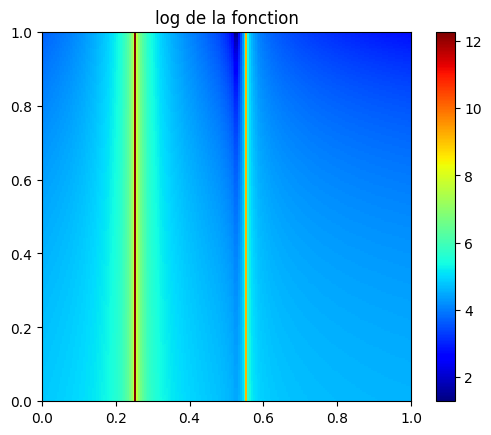

In [0]:
def utility(x,y):
    return np.abs(1/(x-0.55266)+10/(x-0.25121))+100*np.sin(y)

x=np.linspace(0,1,200)
XX,YY=np.meshgrid(x,x)
plt.imshow(np.log(utility(XX,YY)),extent=[0,1,0,1],cmap='jet')
plt.colorbar()
plt.title("log de la fonction")

### Il n'y a pas que les hyper-paramètres à tester...

Dans votre recherche de modèle optimale, vous pouvez aussi: 
* Tester plusieurs types de modèle (forêt, neurones...)
* Testez différentes prétraitement des descripteurs
* Ajouter ou pas des nouveaux descripteurs


## Analysons le meilleur modèle 

On gagne beaucoup en inspectant notre meilleurs modèle. Notamment, les random forest peuvent indiquer quelles sont les descripteurs qui ont le plus d'influence sur la cible. 



In [0]:
best_params=results[0]
best_params

{'bias': 33047.0,
 'bootstrap': True,
 'max_features': 5,
 'n_estimators': 23,
 'std': 757.0}

In [0]:
best_model= RandomForestRegressor(
                random_state=42,
                bootstrap=best_params["bootstrap"],
                n_estimators=best_params["n_estimators"],
                max_features=best_params["max_features"]
            )
best_model.fit(X_train,Y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=23,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [0]:
feature_importances=best_model.feature_importances_
named_feature_importances=[]
for i in range(len(feature_importances)):
    named_feature_importances.append((X_names[i],feature_importances[i]))
named_feature_importances.sort(key=lambda pair:-pair[1])
named_feature_importances

[('median_income', 0.3436099770301179),
 ('population_per_household', 0.11721512927508075),
 ('longitude', 0.10102853070072582),
 ('bedrooms_per_room', 0.09880556152497809),
 ('latitude', 0.09146186003021707),
 ('rooms_per_household', 0.05192637799319466),
 ('housing_median_age', 0.04763458280557973),
 ('<1H OCEAN', 0.04078967644967327),
 ('NEAR OCEAN', 0.02497235303724652),
 ('population', 0.018636548057193527),
 ('total_rooms', 0.01828038684796301),
 ('total_bedrooms', 0.018238245840410915),
 ('households', 0.017695027370743382),
 ('NEAR BAY', 0.009619915254895722),
 ('ISLAND', 8.582778197958322e-05)]

A partir de cette information, vous pouvez décider de supprimer les descripteurs qui ont très peu d'importance. Vous obtiendrais un modèle plus simple et sans doute avec une moindre variance. 

Vous pouvez aussi regarder sur quelles données le meilleurs modèle fait de grosses erreur, et essayer de comprendre pourquoi: des donnée atypique ? manque-t-il un descripteur pour les capter ?  Données abhérente ? faut-il les supprimmer ? 


## Evaluons le modèle sur les données test 

C'est l'étape ultime. Si vous n'effectuer ce calcul qu'une fois à la toute fin de votre projet, l'erreur obtenu sera sans doute proche de l'erreur que l'on obtiendrais avec de nouvelles données entrantes. 

Biensur, la tentation est très grande de reprendre le projet à zéro quand l'erreur sur test nous semble trop grande. Et là, on triche !  

In [0]:
Y_test_hat=best_model.predict(X_test)
mae_test=np.mean(np.abs(Y_test-Y_test_hat))
squared_errors=(Y_test-Y_test_hat)**2

mse_test=np.mean(squared_errors)
rmse_test=np.sqrt(np.mean((Y_test-Y_test_hat)**2))
print("mae_test:",mae_test)
print("rmse_test:",rmse_test)

mae_test: 57276.28842819257
rmse_test: 79428.8569661941


###  Persistence

Quand on a bien travailler, il faut sauverager son travail.  

In [0]:
from sklearn.externals import joblib
""" the file my_model.pkl contain the description of the model, and all its parameters and hyperparameters. """
joblib.dump(best_model, "my_model.pkl") 
""" and one week later: """
best_model_one_week_later = joblib.load("my_model.pkl") 
best_model_one_week_later.predict(X_test)

array([386547.895, 284079.   , 215100.   , ..., 335568.579, 223821.053, 168126.368])

## Débat: Utilisez ces propres fonctions où des fonctions prédéfinies?

C'est un dilemme que l'on a très souvent. Dans ce tuto le choix c'est posé pour:

* Le remplacement des valeurs manquantes: Nous l'avons fait à la main, on aurait put utiliser un outil tout fait:
```
from sklearn.preprocessing import Imputer
#remplacement des valeurs manquantes de chaque colonne par la médiane de la colonne
imputer = Imputer(strategy="median")
imputer.fit_transform(data_train)
#puis plus loin
inputer.transform(data_test)
```
* La standardisation pour laquel j'ai utilisé `sklearn` mais c'était facile à faire à la main. Notamment si on avait voulu utilisé le tanh-estimator, on l'aurait fait à la main.  
* La cross-validation: Ici le programme maison n'était pas élémentaire. Mais je trouve qu'il était riche d'enseignement
* La création du pipeline. `sklearn` propose une classe qui permet d'emboiter les différents  traitements de données. 
* La recherche en grille ou aléatoire. Dans ce cas, les classes `sklearn` sont, à mon avis, inutiles. De plus on a facilement envie de se faire un process maison, mélangeant grille et aléat, tout en alternant des modèles. 

De manière générale coder les choses soi-même est beaucoup plus formateur et permet plus de personnalisation.  MAIS, ne surtout pas recoder les "traitement lourds" qui demandement des optimisations, comme par exemple les différents modèles (à l'exception du modèle linéaire ou ridge qui se code en 2 lignes). 